## TODO
- izbaciti vremena eksperimenata
- promjena sata sa 26. na 27.
- izbaciti outliere (boxplot) ?
- normalizirati data?
- gledati korelacije izmedju svakih od vrata odvojeno za pocetak ili ako su barem jedna vrata otvorena
- Door hallway i Door Garden vjv imaju drugčiji utjecaj na stanje u sobi
- confusion matrix za korelacije, da vidimo sto ce najvise pridonjeti korelaciji
- za svaki od poluatanata i uvjete provjeriti korelaciju nekim modelom
- Feature selection kao kombinacija parametara?
- https://hal.science/hal-04432021v1/document, feature selection
- KADA SU SE KOMBINIRALI PARAMETRI: Except for	RFC	models, features are normalized between	0	and	1	based	on	the	training	set	characteristics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns


c:\Users\tjura\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### DATA LOADING

In [ ]:
# Load and preprocess door and window data
door_df = pd.read_csv('Door_windows.csv')
door_df = door_df.drop('Door_balcony_1st_floor', axis=1)
door_df = door_df.drop_duplicates(subset='Date')
door_df['Date'] = pd.to_datetime(door_df['Date'], format='%d/%m/%Y %H:%M')
door_df = door_df.sort_values('Date')

door_df['Door_Garden'] = door_df['Door_Garden'].map({'on': 1, 'off': 0})
door_df['Door_Hallway'] = door_df['Door_Hallway'].map({'on': 1, 'off': 0})

# Create a new dataframe with 1-second intervals
start_time = door_df['Date'].min()
end_time = door_df['Date'].max()
time_range = pd.date_range(start=start_time, end=end_time, freq='1S')
door_df_1s = pd.DataFrame({'Date': time_range})

# Merge with the original dataframe to fill in missing rows
door_df_1s = pd.merge(door_df_1s, door_df, on='Date', how='left')

# Fill missing values based on the last known status
door_df_1s['Door_Garden'] = door_df_1s['Door_Garden'].fillna(method='ffill')
door_df_1s['Door_Hallway'] = door_df_1s['Door_Hallway'].fillna(method='ffill')
    
# Create a binary state for any door being open
door_df_1s["any_door_open"] = ((door_df_1s["Door_Garden"] == 1) | (door_df_1s["Door_Hallway"] == 1)).astype(int)
door_df_1s['Date'] = pd.to_datetime(door_df_1s['Date'], format='%d/%m/%Y %H:%M')
#door_df_1s.to_csv("door_windows_combined.csv", index=False)

sensor_df = pd.read_csv('LS0623020168.csv')
# Convert UTC to UTC+1
sensor_df['timestamp(UTC+1)'] = pd.to_datetime(sensor_df['timestamp(UTC)']) + timedelta(hours=1)

merged_df = pd.merge(sensor_df, door_df_1s[["Date", "Door_Garden", "Door_Hallway", "any_door_open"]],
                     left_on="timestamp(UTC+1)", right_on="Date", how="left")
merged_df = merged_df.drop(columns=["Date"])
merged_df = merged_df[merged_df["timestamp(UTC+1)"] >= start_time]

#merged_df.to_csv("merged_sensor_data.csv", index=False)

### Visualizing the data

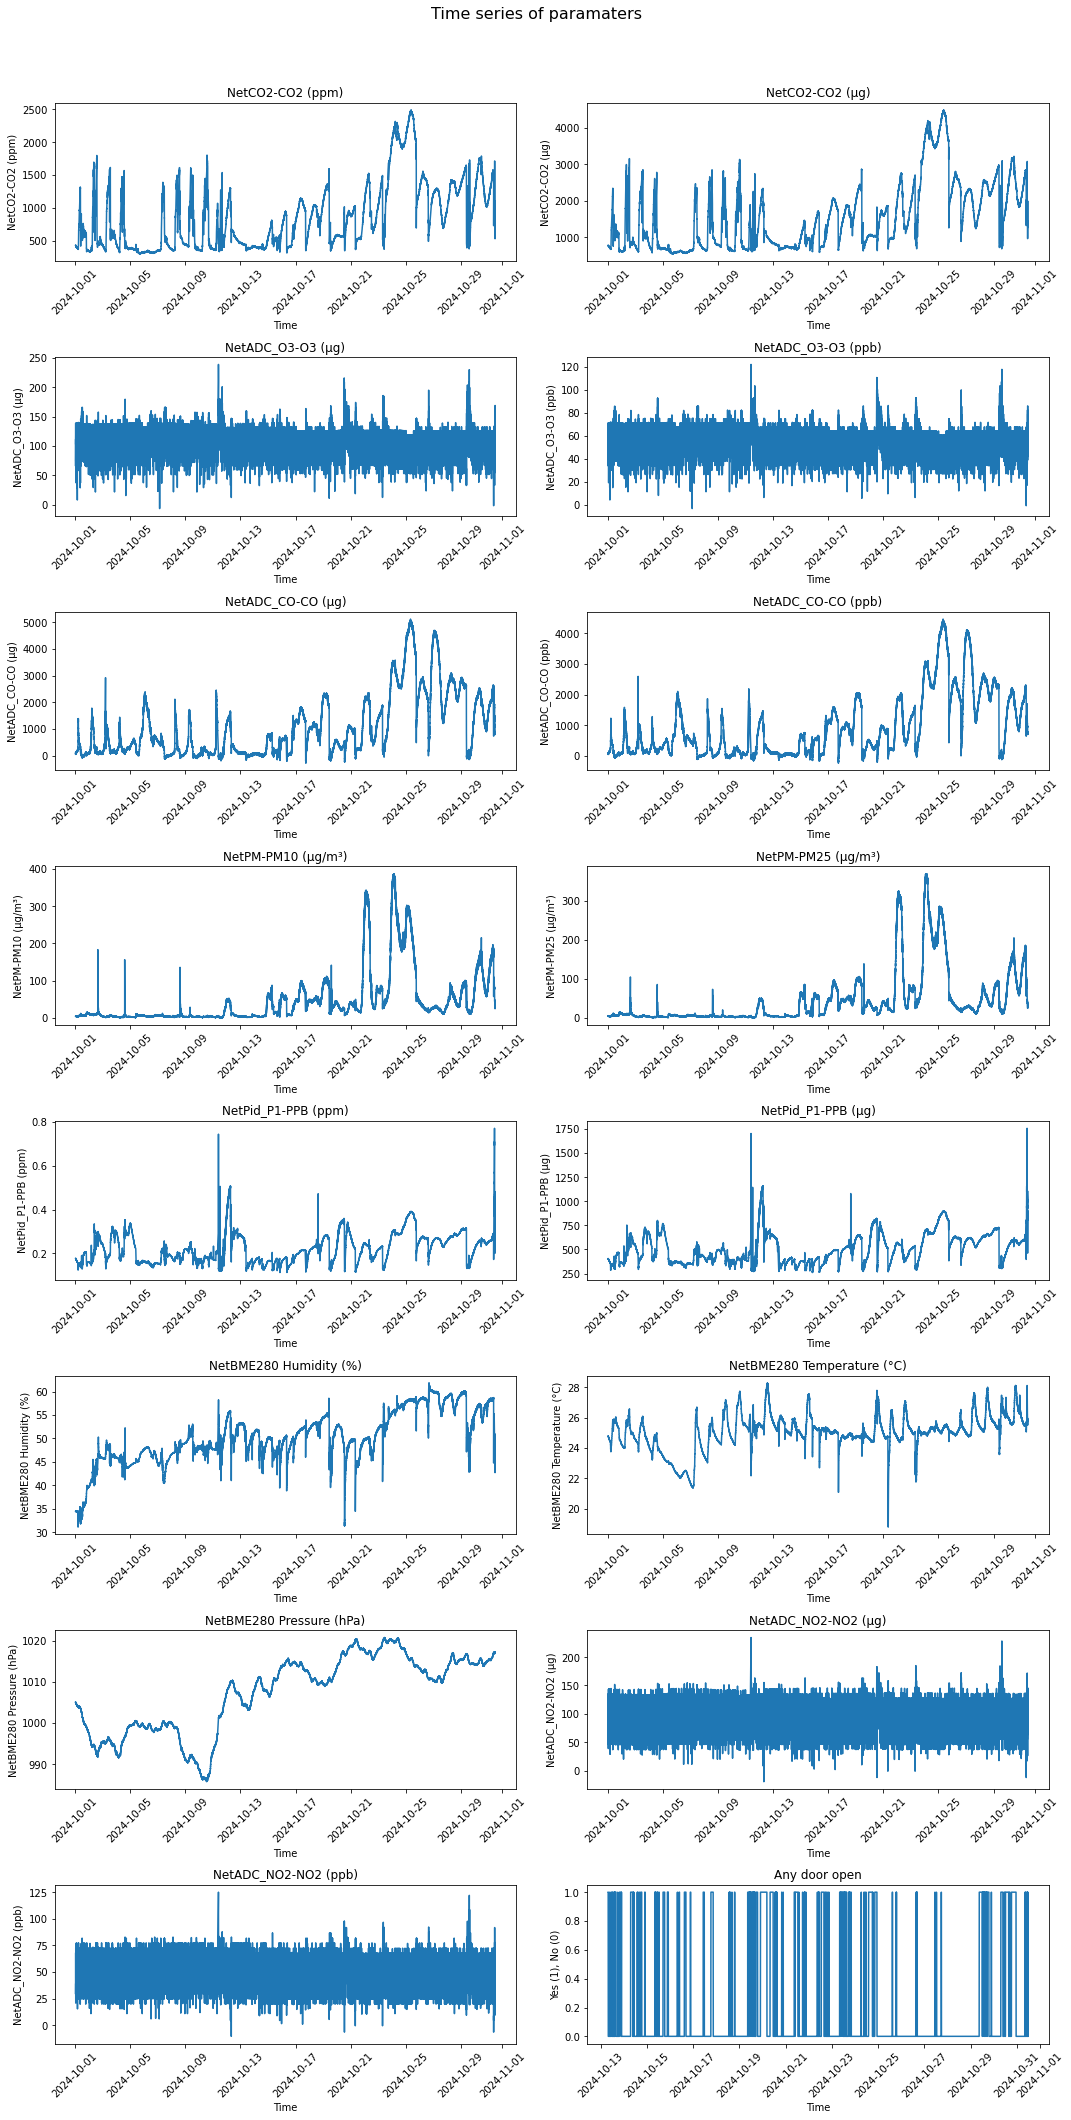

In [4]:
# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of paramaters', fontsize=16)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(sensor_df['timestamp(UTC+1)'], sensor_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

axs[7,1].plot(merged_df['timestamp(UTC+1)'],merged_df['any_door_open'])
axs[7,1].set_title('Any door open')
axs[7,1].set_xlabel('Time')
axs[7,1].set_ylabel('Yes (1), No (0)')
axs[7,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


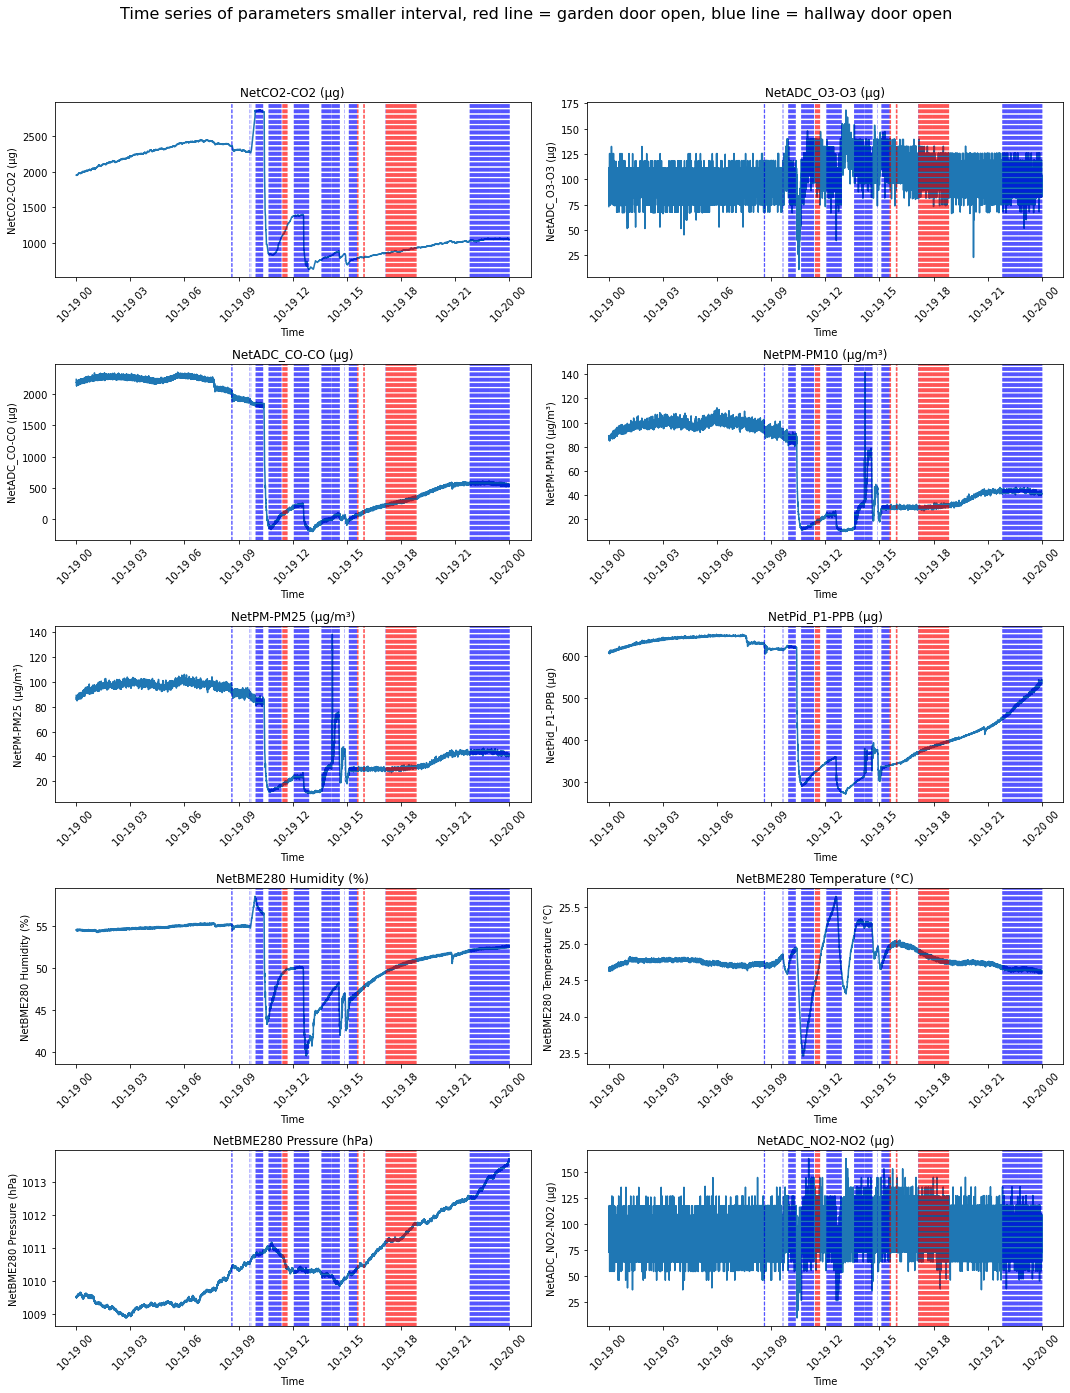

In [ ]:
#20-21 3 min generiranje
start_time = '2024-10-19'  
end_time = '2024-10-20'    
filtered_merged_df = merged_df[(merged_df['timestamp(UTC+1)'] >= start_time) & (merged_df['timestamp(UTC+1)'] <= end_time)]

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of parameters smaller interval, red line = garden door open, blue line = hallway door open', fontsize=16)

# List of parameters and titles
parameters = [
    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    #('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    #('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

open_door_times = filtered_merged_df[filtered_merged_df['any_door_open'] == 1]['timestamp(UTC+1)']

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(filtered_merged_df['timestamp(UTC+1)'], filtered_merged_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

    # Add vertical lines for door open times with color
    for open_time in open_door_times:
        open_time_door_data = filtered_merged_df[filtered_merged_df['timestamp(UTC+1)'] == open_time]
        if (open_time_door_data['Door_Garden'].values == 1):
            axs[row, col].axvline(x=open_time, color='red', linestyle='--', lw=1, alpha=0.025)
        if (open_time_door_data['Door_Hallway'].values == 1):
            axs[row, col].axvline(x=open_time, color='blue', linestyle='--', lw=1, alpha=0.025)

# Remove unused subplots if they exist
for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()



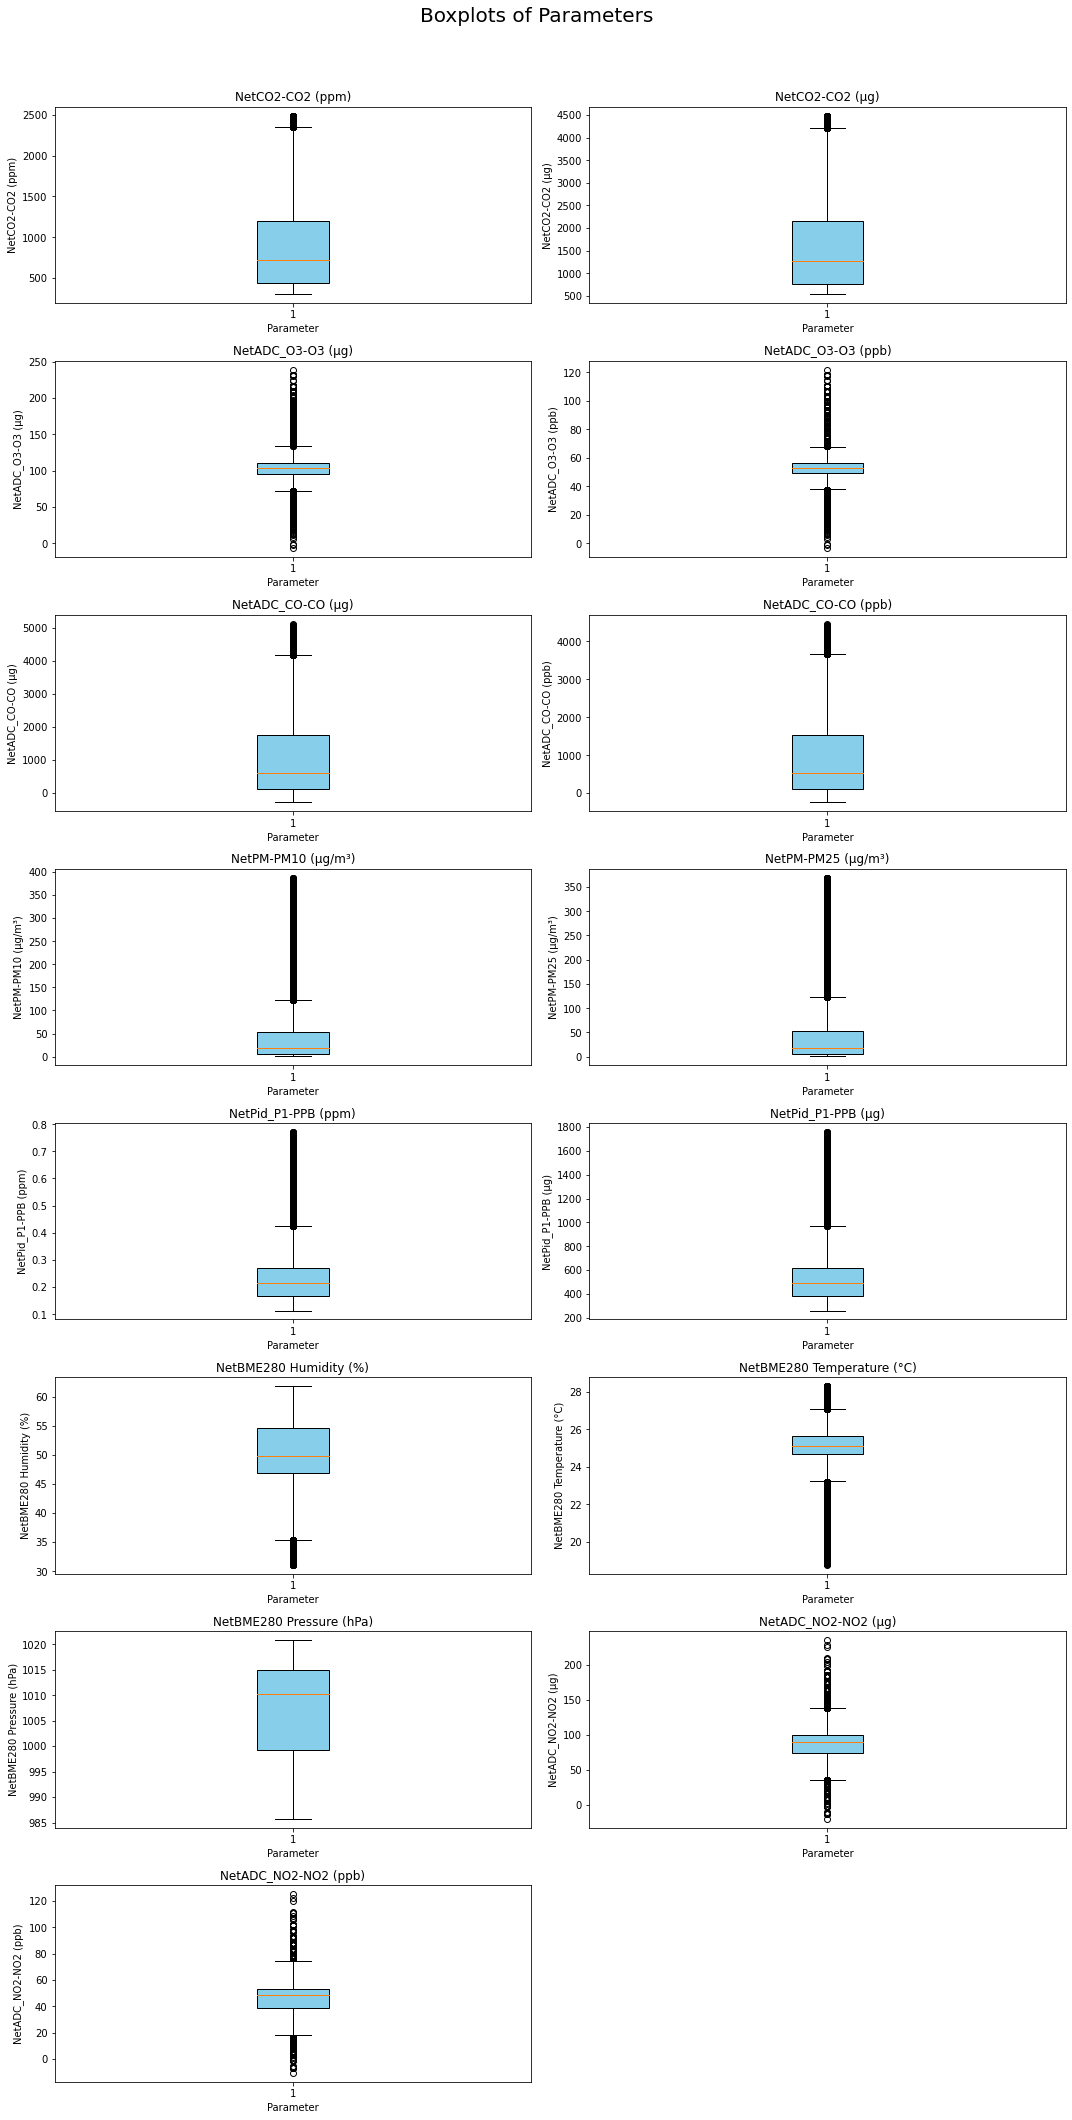

In [ ]:
import matplotlib.pyplot as plt

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Boxplots of Parameters', fontsize=20)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot as a boxplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    box = axs[row, col].boxplot(merged_df[param].dropna(),
                                patch_artist=True,  # Enables coloring
                                boxprops=dict(facecolor='skyblue', color='black'))
    axs[row, col].set_title(title, fontsize=12)
    axs[row, col].set_xlabel('Parameter')
    axs[row, col].set_ylabel(title)

for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


In [162]:
# Create features from sensor data
def create_features(sensor_df):
    # Calculate rolling means and standard deviations
    windows = [3, 5]
    features = {}
    
    for col in sensor_df.columns:
        if col not in ['timestamp(UTC)', 'timestamp(UTC+1)']:
            # Original value
            features[col] = sensor_df[col]
            
            # Rolling statistics
            for window in windows:
                features[f'{col}_rolling_mean_{window}'] = sensor_df[col].rolling(window=window).mean()
                features[f'{col}_rolling_std_{window}'] = sensor_df[col].rolling(window=window).std()
    
    return pd.DataFrame(features)

# Analyze changes during door events
def analyze_door_events(sensor_df, door_df, window_minutes=5):
    results = []
    
    # Get door state changes
    door_changes = door_df[door_df['any_door_open'].diff() != 0]
    
    for _, door_event in door_changes.iterrows():
        event_time = door_event['Date']
        door_state = door_event['any_door_open']
        
        # Get sensor data around the event
        before_event = sensor_df[
            (sensor_df['timestamp(UTC+1)'] >= event_time - pd.Timedelta(minutes=window_minutes)) &
            (sensor_df['timestamp(UTC+1)'] < event_time)
        ]
        
        after_event = sensor_df[
            (sensor_df['timestamp(UTC+1)'] >= event_time) &
            (sensor_df['timestamp(UTC+1)'] < event_time + pd.Timedelta(minutes=window_minutes))
        ]
        
        if len(before_event) == 0 or len(after_event) == 0:
            continue
            
        # Calculate changes in measurements
        for col in sensor_df.columns:
            if col not in ['timestamp(UTC)', 'timestamp(UTC+1)']:
                before_mean = before_event[col].mean()
                after_mean = after_event[col].mean()
                pct_change = ((after_mean - before_mean) / before_mean) * 100
                
                results.append({
                    'event_time': event_time,
                    'measurement': col,
                    'door_state': 'opened' if door_state == 1 else 'closed',
                    'before_mean': before_mean,
                    'after_mean': after_mean,
                    'pct_change': pct_change
                })
    
    return pd.DataFrame(results)

# Train classification model
def train_door_state_model(features_df, door_states, test_size=0.2):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, door_states, test_size=test_size, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': features_df.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return model, scaler, report, feature_importance


In [168]:
# Main analysis
def main():    
    # Analyze door events
    event_analysis = analyze_door_events(sensor_df, door_df)
    
    # Create features
    features_df = create_features(sensor_df)
    
    # Create target variable by matching door states to sensor timestamps
    door_states = []
    for timestamp in sensor_df['timestamp(UTC+1)']:
        # Find the most recent door state before this timestamp
        prev_states = door_df[door_df['Date'] <= timestamp]
        if len(prev_states) > 0:
            door_states.append(prev_states.iloc[-1]['any_door_open'])
        else:
            door_states.append(0)
    
    # Train and evaluate model
    model, scaler, report, feature_importance = train_door_state_model(features_df, door_states)
    
    return event_analysis, model, scaler, report, feature_importance

In [169]:
main()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Complete analysis

In [ ]:
# Part 1: Statistical Analysis of Changes During Door Events
def analyze_measurements_around_door_events(sensor_df, door_df, window_minutes=5):
    results = []
    
    # Get times when door state changes
    door_changes = door_df[door_df['any_door_open'].diff() != 0]
    
    # Analyze each door event
    for _, door_event in door_changes.iterrows():
        event_time = door_event['Date']
        door_state = door_event['any_door_open']
        
        # Get measurements before and after door event
        before_event = sensor_df[
            (sensor_df['timestamp(UTC+1)'] >= event_time - pd.Timedelta(minutes=window_minutes)) &
            (sensor_df['timestamp(UTC+1)'] < event_time)
        ]
        
        after_event = sensor_df[
            (sensor_df['timestamp(UTC+1)'] >= event_time) &
            (sensor_df['timestamp(UTC+1)'] < event_time + pd.Timedelta(minutes=window_minutes))
        ]
        
        if len(before_event) == 0 or len(after_event) == 0:
            continue
        
        # Calculate changes for each measurement
        measurements = sensor_df.columns[1:-1]  # Exclude timestamps
        for measure in measurements:
            before_mean = before_event[measure].mean()
            after_mean = after_event[measure].mean()
            pct_change = ((after_mean - before_mean) / before_mean) * 100 if before_mean != 0 else np.nan
            
            results.append({
                'event_time': event_time,
                'measurement': measure,
                'door_action': 'opened' if door_state == 1 else 'closed',
                'before_mean': before_mean,
                'after_mean': after_mean,
                'pct_change': pct_change
            })
    
    return pd.DataFrame(results)

# Part 2: Predictive Modeling
def prepare_features_for_modeling(sensor_df):
    features = {}
    
    # Calculate rolling statistics for each measurement
    for col in sensor_df.columns:
        if col not in ['timestamp(UTC)', 'timestamp(UTC+1)']:
            # Original values
            features[col] = sensor_df[col]
            
            # Rolling mean and standard deviation
            features[f'{col}_rolling_mean_3'] = sensor_df[col].rolling(window=3).mean()
            features[f'{col}_rolling_std_3'] = sensor_df[col].rolling(window=3).std()
            
            # Rate of change
            features[f'{col}_rate_of_change'] = sensor_df[col].diff()
    
    return pd.DataFrame(features)

# Run analyses
print("Running Statistical Analysis of Door Events...")
event_analysis = analyze_measurements_around_door_events(sensor_df, door_df)

# Prepare data for modeling
print("\nPreparing Data for Predictive Modeling...")
features_df = prepare_features_for_modeling(sensor_df)

# Create target variable by matching door states to sensor timestamps
door_states = []
for timestamp in sensor_df['timestamp(UTC+1)']:
    prev_states = door_df[door_df['Date'] <= timestamp]
    if len(prev_states) > 0:
        door_states.append(prev_states.iloc[-1]['any_door_open'])
    else:
        door_states.append(0)

# Remove rows with NaN values (from rolling calculations)
features_df = features_df.dropna()
door_states = door_states[features_df.index]

# Split data and train model
X_train, X_test, y_train, y_test = train_test_split(
    features_df, door_states, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Get predictions
y_pred = model.predict(X_test_scaled)

# Calculate feature importance
feature_importance = pd.DataFrame({
    'feature': features_df.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Print results
print("\nStatistical Analysis Results:")
print("\nMean Changes During Door Events:")
stat_summary = event_analysis.groupby(['measurement', 'door_action'])['pct_change'].agg(['mean', 'count']).round(2)
print(stat_summary)

print("\nModel Performance:")
print(classification_report(y_test, y_pred))

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Create visualizations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=event_analysis, x='measurement', y='pct_change', hue='door_action')
plt.xticks(rotation=45)
plt.title('Measurement Changes During Door Events')
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features for Door State Prediction')
plt.tight_layout()

plt.show()